Treinar o modelo ERA com neural networks

In [1]:
import pandas as pd
import numpy as np

## Read file as a pandas dataframe and print its head
df = pd.read_csv('oceanographic and meteorological dataset.csv')
df.head(5)

,time,u10_era5,v10_era5,mwd_era5,mwp_era5,swh_era5,pp1d_era5,uo_cop,vo_cop,swh_cop,mwp_cop,mwd_cop,peak_period_cop
0,2025-01-01 00:00:00,-6.306534,14.981308,172.33765,8.959626,4.751488,10.330421,0.019531,0.160156,5.10,7.56,175.07,10.85
1,2025-01-01 01:00:00,-4.723419,14.342773,171.36377,8.907424,4.758851,10.286964,0.026367,0.164062,NaN,NaN,NaN,NaN
2,2025-01-01 02:00:00,-3.978439,12.770416,171.11426,8.913869,4.665862,10.272316,0.038086,0.162109,NaN,NaN,NaN,NaN
3,2025-01-01 03:00:00,-3.164124,15.130005,171.06311,8.911307,4.565788,10.260597,0.053711,0.155273,5.03,7.60,174.16,10.71
4,2025-01-01 04:00:00,-3.343689,12.074799,171.16702,8.862277,4.541395,10.223000,0.070312,0.143555,NaN,NaN,NaN,NaN


Transformar o tempo para variaveis cosseno e seno, treinar modelo com a variavel mwd_era5

In [2]:
# 1. Criar as variáveis cíclicas (Substitui 'data_col' pelo nome da tua coluna de tempo)
# Se a coluna já for datetime, ignora a linha do pd.to_datetime
df['time'] = pd.to_datetime(df['time']) 

df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
df['month_sin'] = np.sin(2 * np.pi * df['time'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['time'].dt.month / 12)

# 2. Definir X e y (Removendo a coluna de tempo original também)
colunas_para_remover = [
    'uo_cop', 'vo_cop', 'swh_cop', 'mwd_cop', 
    'mwp_cop', 'peak_period_cop', 'mwd_era5', 'time'
]
X = df.drop(columns=colunas_para_remover, errors='ignore')
y = df['mwd_era5']

In [3]:
from sklearn.model_selection import train_test_split

seed = 42
# Mantemos X como DataFrame para usar nomes de colunas depois
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.66, random_state=seed)

# Reshape apenas do y (que precisa de ser 2D para o scaler)
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Identificar colunas numéricas que NÃO são as de seno/cosseno
colunas_para_escalar = [c for c in X.columns if 'sin' not in c and 'cos' not in c]

preprocessor_X = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_para_escalar)
    ], 
    remainder='passthrough' # Isto mantém as colunas sin/cos intactas
)

# Aplicar o transformador
X_train_scaled = preprocessor_X.fit_transform(X_train)
X_val_scaled = preprocessor_X.transform(X_val)
X_test_scaled = preprocessor_X.transform(X_test)

# Escalar o Y
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

In [5]:
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

seed = 42

# 2) Seed Python and NumPy
random.seed(seed)
np.random.seed(seed)

# 3) Import and seed TensorFlow
tf.random.set_seed(seed)

In [6]:
# 1. Determinar o número de features (colunas) que entrarão na rede
n_features = X_train_scaled.shape[1]

# 2. Definir o modelo (Baseado no que você mostrou antes)
model = Sequential([
    Input(shape=(n_features,)),
    Dense(40, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='linear') # 'linear' ou None para regressão
])

# 3. Compilar
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=MeanSquaredError()
)

# 4. Treinar (Usando as versões SCALED que criámos)
history = model.fit(
    X_train_scaled, y_train_scaled, 
    epochs=400, 
    batch_size=32, 
    verbose=1, # Mude para 1 para ver o erro a descer!
    validation_data=(X_val_scaled, y_val_scaled)
)

Epoch 1/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0292 - val_loss: 0.9676
Epoch 2/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8863 - val_loss: 0.8661
Epoch 3/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8167 - val_loss: 0.8117
Epoch 4/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7759 - val_loss: 0.7788
Epoch 5/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7493 - val_loss: 0.7556
Epoch 6/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7299 - val_loss: 0.7367
Epoch 7/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7143 - val_loss: 0.7210
Epoch 8/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7016 - val_loss: 0.7080
Epoch 9/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6911 - val_loss: 0.6972
Epoch 10/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6823 - val_loss: 0.6883
Epoch 11/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6747 - val_loss: 0.6805
Epoch 12/400
175/175 ━━━━━━━━━━━━━━━━━━━━

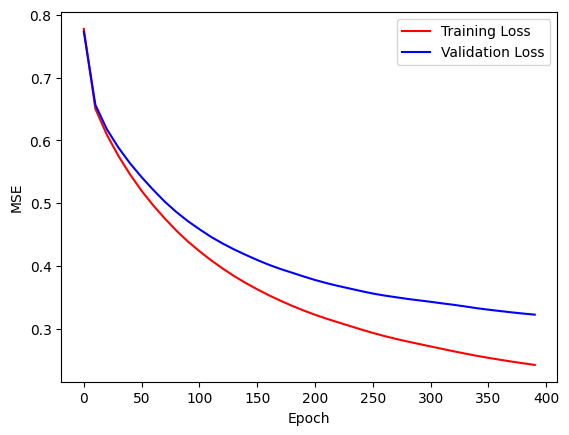

In [7]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow
losses = pd.DataFrame(data={
    'epoch': [(i // 10) * 10 for i in history.epoch],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
losses = losses.groupby(by='epoch').mean().reset_index()

fig, ax = plt.subplots()
ax.plot(losses.epoch, losses.loss, 'r-', label='Training Loss')
ax.plot(losses.epoch, losses.val_loss, 'b-', label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

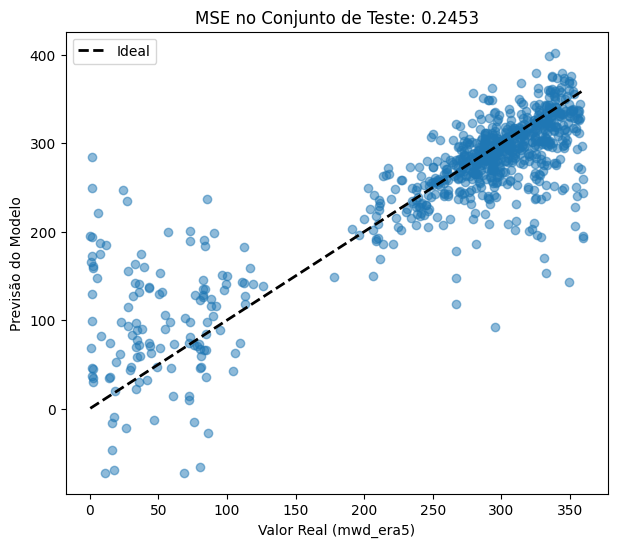

In [8]:
fig, ax = plt.subplots(figsize=(7, 6))

# 1. Obter previsões (em escala normalizada)
y_pred_scaled = model.predict(X_test_scaled, verbose=0)

# 2. Inverter para a escala real (ex: graus ou metros)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
# Certifica-te que y_test são os valores REAIS (não os scaled)
# Se y_test já for o array original, podes usar diretamente

ax.scatter(y_test, y_pred, color='tab:blue', alpha=0.5)

# 3. Linha de Identidade (A linha do "perfeito")
# Se o modelo fosse perfeito, todos os pontos estariam em cima desta linha
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')

# Ajustar os nomes dos eixos para o teu caso
ax.set_xlabel('Valor Real (mwd_era5)')
ax.set_ylabel('Previsão do Modelo')

# Calcular o erro no conjunto de teste
test_loss = MeanSquaredError()(y_test_scaled, y_pred_scaled).numpy()
ax.set_title(f'MSE no Conjunto de Teste: {test_loss:.4f}')
ax.legend()
plt.show()

train it with a learning rate of 1e-3 and 1e-5.

In [24]:
# Define model
def create_model(learning_rate, n_features=X_train.shape[1]):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation=None))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError()
    )
    return model

def format_history(history):
    return pd.DataFrame(data={
        'epoch': [(i // 10) * 10 for i in history.epoch],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }).groupby(by='epoch').mean().reset_index()

model_1e_3 = create_model(learning_rate=1e-3)
history_1e_3 = model_1e_3.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                         validation_data=(X_val_scaled, y_val_scaled))
losses_1e_3 = format_history(history_1e_3)

model_1e_4 = create_model(learning_rate=1e-4)
history_1e_4 = model_1e_4.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                         validation_data=(X_val_scaled, y_val_scaled))
losses_1e_4 = format_history(history_1e_4)

model_1e_5 = create_model(learning_rate=1e-5)
history_1e_5 = model_1e_5.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                              validation_data=(X_val_scaled, y_val_scaled))
losses_1e_5 = format_history(history_1e_5)

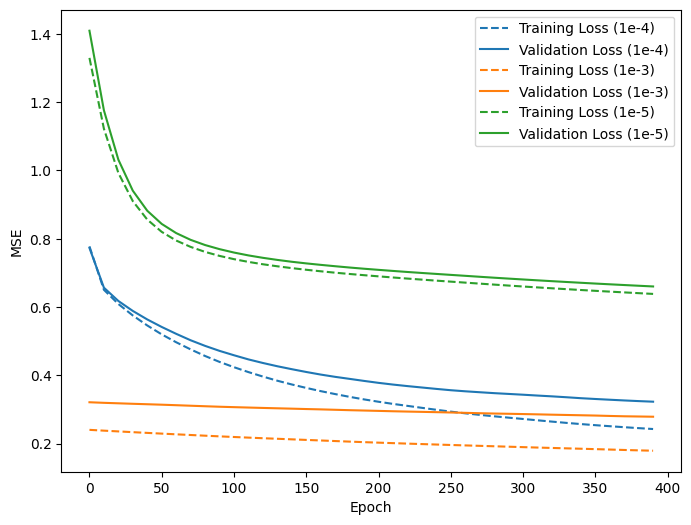

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(losses.epoch, losses.loss, color='tab:blue', linestyle='--', label='Training Loss (1e-4)')
ax.plot(losses.epoch, losses.val_loss, color='tab:blue', linestyle='-', label='Validation Loss (1e-4)')
ax.plot(losses_1e_3.epoch, losses_1e_3.loss, color='tab:orange', linestyle='--', label='Training Loss (1e-3)')
ax.plot(losses_1e_3.epoch, losses_1e_3.val_loss, color='tab:orange', linestyle='-', label='Validation Loss (1e-3)')
ax.plot(losses_1e_5.epoch, losses_1e_5.loss, color='tab:green', linestyle='--', label='Training Loss (1e-5)')
ax.plot(losses_1e_5.epoch, losses_1e_5.val_loss, color='tab:green', linestyle='-', label='Validation Loss (1e-5)')


ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

In [22]:
# Define model
def create_model(learning_rate, n_features=X_train.shape[1]):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError()
    )
    return model

def format_history(history):
    return pd.DataFrame(data={
        'epoch': [(i // 10) * 10 for i in history.epoch],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }).groupby(by='epoch').mean().reset_index()

model_1e_3 = create_model(learning_rate=1e-3)
history_1e_3 = modelmodel_1e_3.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                         validation_data=(X_val_scaled, y_val_scaled))
losses_1e_3 = format_history(history_1e_3)

model_1e_4 = create_model(learning_rate=1e-4)
history_1e_4 = model_1e_4.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                         validation_data=(X_val_scaled, y_val_scaled))
losses_1e_4 = format_history(history_1e_4)

model_1e_5 = create_model(learning_rate=1e-5)
history_1e_5 = model_1e_5.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                              validation_data=(X_val_scaled, y_val_scaled))
losses_1e_5 = format_history(history_1e_5)

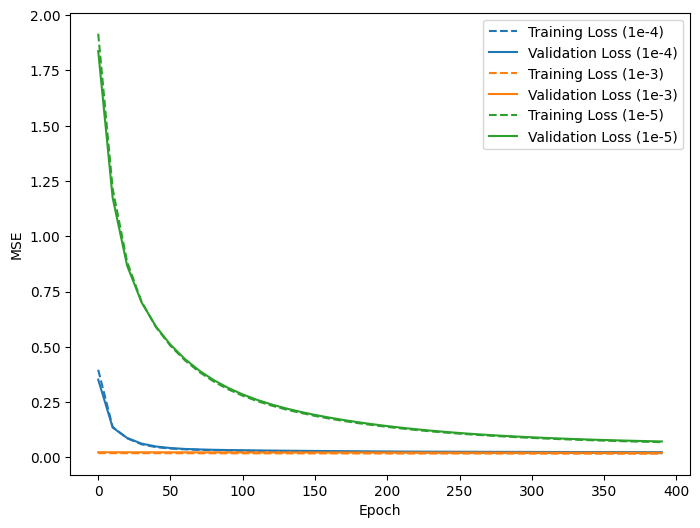

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(losses.epoch, losses.loss, color='tab:blue', linestyle='--', label='Training Loss (1e-4)')
ax.plot(losses.epoch, losses.val_loss, color='tab:blue', linestyle='-', label='Validation Loss (1e-4)')
ax.plot(losses_1e_3.epoch, losses_1e_3.loss, color='tab:orange', linestyle='--', label='Training Loss (1e-3)')
ax.plot(losses_1e_3.epoch, losses_1e_3.val_loss, color='tab:orange', linestyle='-', label='Validation Loss (1e-3)')
ax.plot(losses_1e_5.epoch, losses_1e_5.loss, color='tab:green', linestyle='--', label='Training Loss (1e-5)')
ax.plot(losses_1e_5.epoch, losses_1e_5.val_loss, color='tab:green', linestyle='-', label='Validation Loss (1e-5)')


ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

In [ ]:
# Define model
def create_model(learning_rate, n_features=X_train.shape[1]):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError()
    )
    return model

def format_history(history):
    return pd.DataFrame(data={
        'epoch': [(i // 10) * 10 for i in history.epoch],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }).groupby(by='epoch').mean().reset_index()

model_1e_3 = create_model(learning_rate=1e-3)
history_1e_3 = modelmodel_1e_3.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                         validation_data=(X_val_scaled, y_val_scaled))
losses_1e_3 = format_history(history_1e_3)

model_1e_4 = create_model(learning_rate=1e-4)
history_1e_4 = model_1e_4.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                         validation_data=(X_val_scaled, y_val_scaled))
losses_1e_4 = format_history(history_1e_4)

model_1e_5 = create_model(learning_rate=1e-5)
history_1e_5 = model_1e_5.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                              validation_data=(X_val_scaled, y_val_scaled))
losses_1e_5 = format_history(history_1e_5)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(losses.epoch, losses.loss, color='tab:blue', linestyle='--', label='Training Loss (1e-4)')
ax.plot(losses.epoch, losses.val_loss, color='tab:blue', linestyle='-', label='Validation Loss (1e-4)')
ax.plot(losses_1e_3.epoch, losses_1e_3.loss, color='tab:orange', linestyle='--', label='Training Loss (1e-3)')
ax.plot(losses_1e_3.epoch, losses_1e_3.val_loss, color='tab:orange', linestyle='-', label='Validation Loss (1e-3)')
ax.plot(losses_1e_5.epoch, losses_1e_5.loss, color='tab:green', linestyle='--', label='Training Loss (1e-5)')
ax.plot(losses_1e_5.epoch, losses_1e_5.val_loss, color='tab:green', linestyle='-', label='Validation Loss (1e-5)')


ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

In [ ]:
# Define model
def create_model(learning_rate, n_features=X_train.shape[1]):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError()
    )
    return model

def format_history(history):
    return pd.DataFrame(data={
        'epoch': [(i // 10) * 10 for i in history.epoch],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }).groupby(by='epoch').mean().reset_index()

model_1e_3 = create_model(learning_rate=1e-3)
history_1e_3 = modelmodel_1e_3.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                         validation_data=(X_val_scaled, y_val_scaled))
losses_1e_3 = format_history(history_1e_3)

model_1e_4 = create_model(learning_rate=1e-4)
history_1e_4 = model_1e_4.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                         validation_data=(X_val_scaled, y_val_scaled))
losses_1e_4 = format_history(history_1e_4)

model_1e_5 = create_model(learning_rate=1e-5)
history_1e_5 = model_1e_5.fit(X_train_scaled, y_train_scaled, epochs=400, batch_size=32, verbose=0,
                              validation_data=(X_val_scaled, y_val_scaled))
losses_1e_5 = format_history(history_1e_5)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(losses.epoch, losses.loss, color='tab:blue', linestyle='--', label='Training Loss (1e-4)')
ax.plot(losses.epoch, losses.val_loss, color='tab:blue', linestyle='-', label='Validation Loss (1e-4)')
ax.plot(losses_1e_3.epoch, losses_1e_3.loss, color='tab:orange', linestyle='--', label='Training Loss (1e-3)')
ax.plot(losses_1e_3.epoch, losses_1e_3.val_loss, color='tab:orange', linestyle='-', label='Validation Loss (1e-3)')
ax.plot(losses_1e_5.epoch, losses_1e_5.loss, color='tab:green', linestyle='--', label='Training Loss (1e-5)')
ax.plot(losses_1e_5.epoch, losses_1e_5.val_loss, color='tab:green', linestyle='-', label='Validation Loss (1e-5)')


ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

converter o mwd_era5 em duas colunas (Seno e Cosseno)

In [11]:
colunas_para_remover = [
    'uo_cop', 'vo_cop', 'swh_cop', 'mwd_cop', 
    'mwp_cop', 'peak_period_cop', 'swh_era5', 'time'
]
X = df.drop(columns=colunas_para_remover, errors='ignore')
y = df['swh_era5']

In [12]:
X.describe()


,u10_era5,v10_era5,mwd_era5,mwp_era5,pp1d_era5,hour_sin,hour_cos,month_sin,month_cos
count,7993.000000,7993.000000,7993.000000,7993.000000,7993.000000,7.993000e+03,7.993000e+03,7.993000e+03,7.993000e+03
mean,2.188604,-0.618673,254.533087,8.491293,10.429202,-1.711241e-17,1.251095e-04,-4.458706e-03,-9.817380e-02
std,5.049941,5.654880,101.285307,1.508553,2.219554,7.071068e-01,7.071952e-01,7.382794e-01,6.673901e-01
min,-10.217163,-17.162354,0.005922,5.044391,4.360695,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,-1.410156,-4.420624,247.110920,7.368544,8.810890,-7.071068e-01,-7.071068e-01,-8.660254e-01,-8.660254e-01
50%,2.046631,-1.186233,291.861820,8.303400,10.276711,0.000000e+00,6.123234e-17,1.224647e-16,-1.836970e-16
75%,5.630310,3.352921,320.586180,9.305229,11.903175,7.071068e-01,7.071068e-01,8.660254e-01,5.000000e-01
max,21.640991,17.548920,359.915250,14.556703,19.234710,1.000000e+00,1.000000e+00,1.000000e+00,8.660254e-01


In [13]:
from sklearn.model_selection import train_test_split

seed = 42
# Mantemos X como DataFrame para usar nomes de colunas depois
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.66, random_state=seed)

# Reshape apenas do y (que precisa de ser 2D para o scaler)
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Identificar colunas numéricas que NÃO são as de seno/cosseno
colunas_para_escalar = [c for c in X.columns if 'sin' not in c and 'cos' not in c]

preprocessor_X = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_para_escalar)
    ], 
    remainder='passthrough' # Isto mantém as colunas sin/cos intactas
)

# Aplicar o transformador
X_train_scaled = preprocessor_X.fit_transform(X_train)
X_val_scaled = preprocessor_X.transform(X_val)
X_test_scaled = preprocessor_X.transform(X_test)

# Escalar o Y
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

In [15]:
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

seed = 42

# 2) Seed Python and NumPy
random.seed(seed)
np.random.seed(seed)

# 3) Import and seed TensorFlow
tf.random.set_seed(seed)

In [16]:
# 1. Determinar o número de features (colunas) que entrarão na rede
n_features = X_train_scaled.shape[1]

# 2. Definir o modelo (Baseado no que você mostrou antes)
model = Sequential([
    Input(shape=(n_features,)),
    Dense(20, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='linear') # 'linear' ou None para regressão
])

# 3. Compilar
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=MeanSquaredError()
)

# 4. Treinar (Usando as versões SCALED que criámos)
history = model.fit(
    X_train_scaled, y_train_scaled, 
    epochs=400, 
    batch_size=32, 
    verbose=1, # Mude para 1 para ver o erro a descer!
    validation_data=(X_val_scaled, y_val_scaled)
)

Epoch 1/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9081 - val_loss: 0.7581
Epoch 2/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6618 - val_loss: 0.5683
Epoch 3/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5065 - val_loss: 0.4462
Epoch 4/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4055 - val_loss: 0.3648
Epoch 5/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3361 - val_loss: 0.3065
Epoch 6/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2858 - val_loss: 0.2631
Epoch 7/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2487 - val_loss: 0.2314
Epoch 8/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2217 - val_loss: 0.2084
Epoch 9/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2018 - val_loss: 0.1914
Epoch 10/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1865 - val_loss: 0.1781
Epoch 11/400
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1741 - val_loss: 0.1673
Epoch 12/400
175/175 ━━━━━━━━━━━━━━━━━━━━

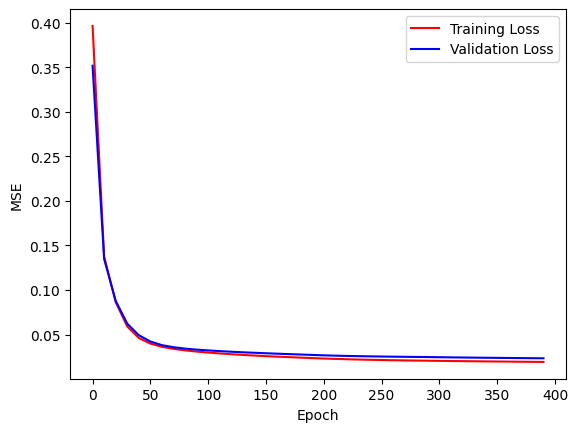

In [17]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow
losses = pd.DataFrame(data={
    'epoch': [(i // 10) * 10 for i in history.epoch],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
losses = losses.groupby(by='epoch').mean().reset_index()

fig, ax = plt.subplots()
ax.plot(losses.epoch, losses.loss, 'r-', label='Training Loss')
ax.plot(losses.epoch, losses.val_loss, 'b-', label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.legend()

Text(0.5, 1.0, 'MSE on Test Set: 0.0288')

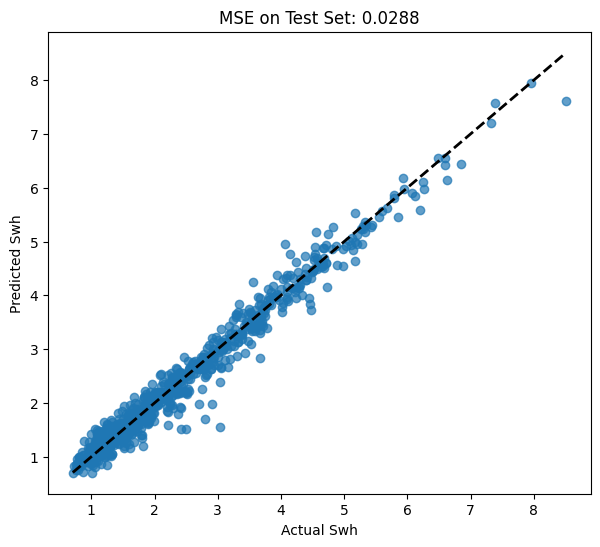

In [18]:
fig, ax = plt.subplots(figsize=(7, 6))
y_pred_scaled = model.predict(X_test_scaled, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
ax.scatter(y_test, y_pred, color='tab:blue', alpha=0.7)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Actual Swh')
ax.set_ylabel('Predicted Swh')

test_loss = MeanSquaredError()(y_test_scaled, y_pred_scaled).numpy()
ax.set_title(f'MSE on Test Set: {test_loss:.4f}')

In [19]:
from sklearn.metrics import mean_absolute_error, r2_score

# Para a Altura (Coluna 0)
mae_swh = mean_absolute_error(y_test_real[:, 0], y_pred_real[:, 0])
r2_swh = r2_score(y_test_real[:, 0], y_pred_real[:, 0])

print(f"Erro Médio (SWH): {mae_swh:.2f} metros")
print(f"Precisão (R²): {r2_swh:.4f}")

NameError: name 'y_test_real' is not defined